# Ekman_spiral
  
an elementary upper ocean Ekman layer
Solve a 1-D diffusion flow numerically.  This version has rotation, and thus makes an Ekman layer.  The IC is a state of rest.  The fluid is forced by an imposed stress at the top of the column (z=0) The lower boundary condition is free-slip to minimize the effect of finite depth. 

Original code by Jim Price, Oct 99
Modified version by Marcello Vichi, for UCT Oceanography

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# user inputs
dz = 5.          #  [m] grid interval
L = 100.         #  [m] water column depth  
ndays = 20.      #  [day] days to integrate
A = 5.e-2       #  [m2/s] the eddy diffusivity
Tauwy = 0.1     #  [N/m2=Pa] the wind stress (y)
Tauwx = 0.       #  [N/m2=Pa] the wind stress (x)
lat = -45.       #  [deg] specify the latitude here

In [4]:
# plot profiles every nplot steps
nplot = 25

#constants
omega = 7.29e-5  # [s-1] 2pi/86400
rho0 = 1025.    #  [kg/m3] nominal constant density of water
SECPERDAY = 86400
w = 0.4          # the Courant number dt*A/dz^2
                  # must be less than 0.5 for numerical stability

In [10]:
# grid specifications
z = np.arange(0, -L - dz, -dz)    # the grid definition
nz = len(z)
dt = w*dz**2/A   # the time step is derived from the Courant number
nstep = round(ndays*SECPERDAY/dt) # number of steps per day
time = np.zeros((nstep, 1))

In [11]:
# derived parameters
f = 2 * omega * np.sin(np.radians(lat))     # the Coriolis parameter
IP = (2 * np.pi / abs(f)) / SECPERDAY      # inertial period



navg 8207
[-3.02768399e-02 -3.02768399e-02 -2.89436736e-02 -2.66997511e-02
 -2.38905274e-02 -2.07904639e-02 -1.76104940e-02 -1.45062593e-02
 -1.15865597e-02 -8.92160143e-03 -6.55075504e-03 -4.48963606e-03
 -2.73640455e-03 -1.27724143e-03 -9.10067489e-05  8.46883429e-04
  1.56130532e-03  2.07493559e-03  2.40635326e-03  2.56867510e-03
  2.56867510e-03]
[ 0.03560198  0.02584588  0.01765141  0.01094983  0.00562549  0.00153358
 -0.00148571 -0.00359628 -0.00495816 -0.00572184 -0.00602468 -0.0059889
 -0.00572074 -0.00531056 -0.00483357 -0.00435092 -0.00391096 -0.00355049
 -0.00329601 -0.00316458 -0.00316458]


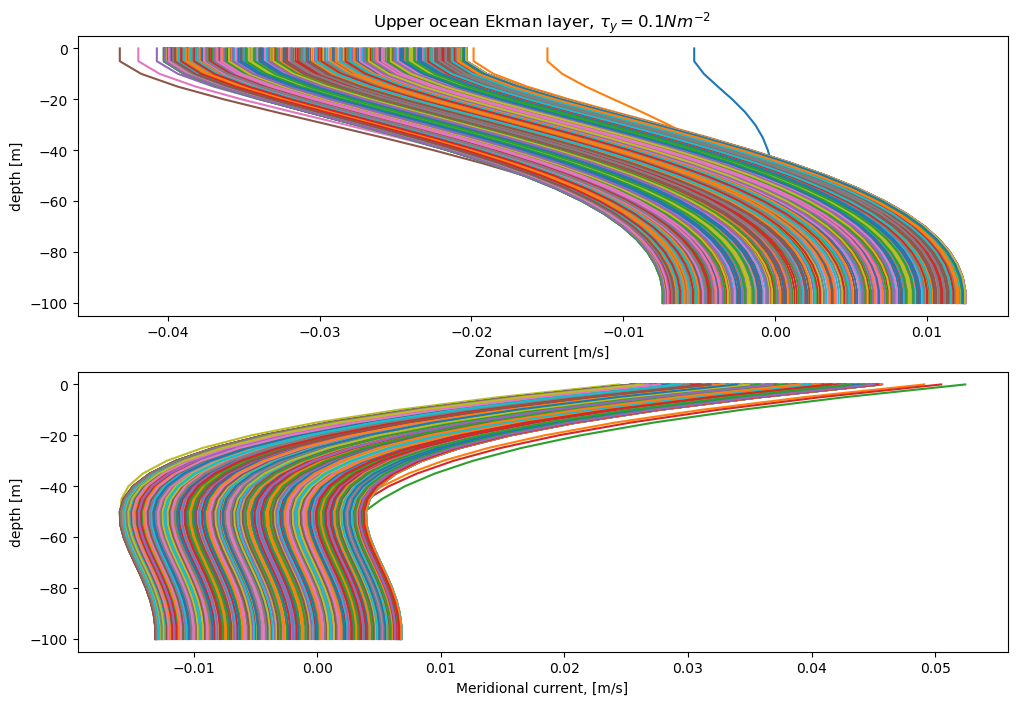

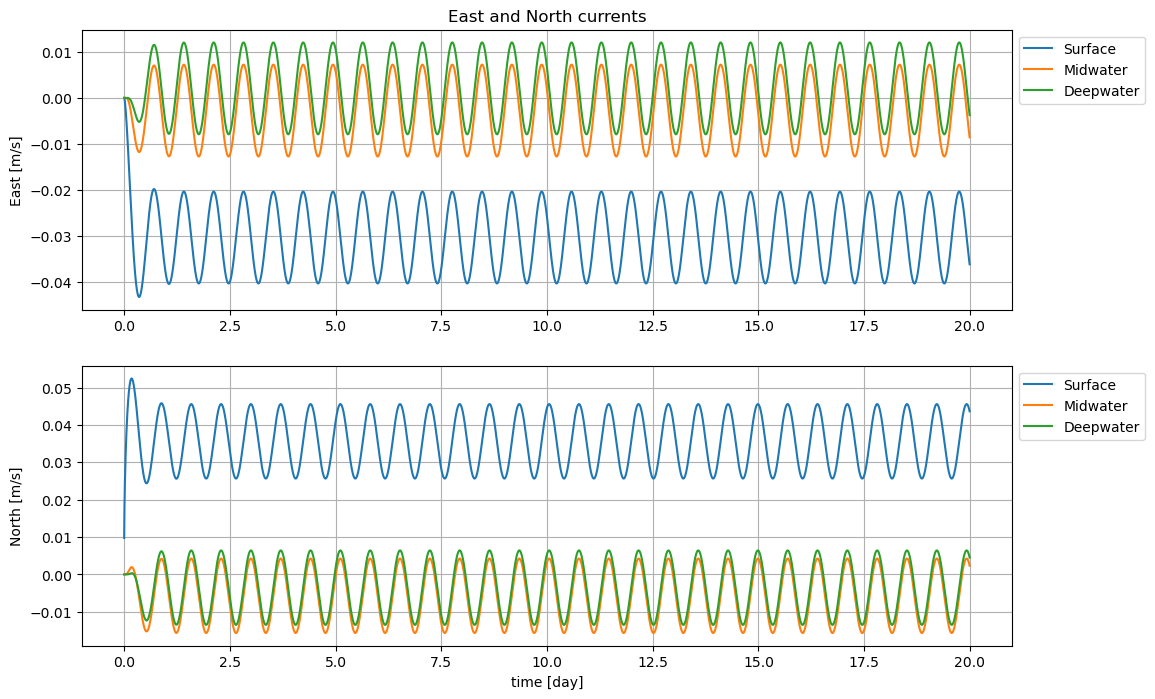

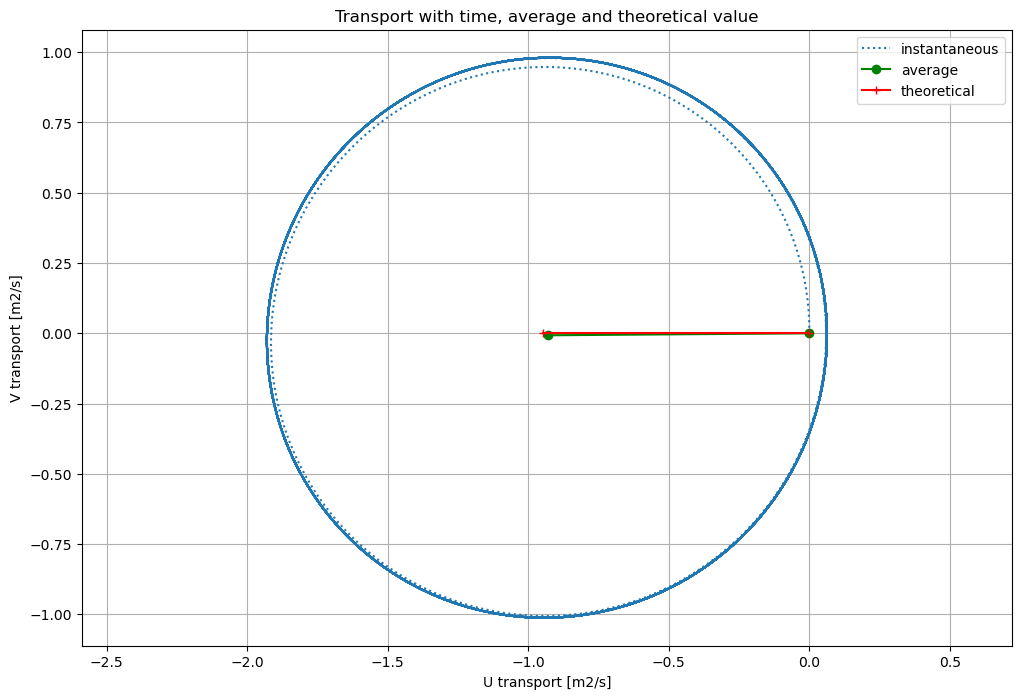

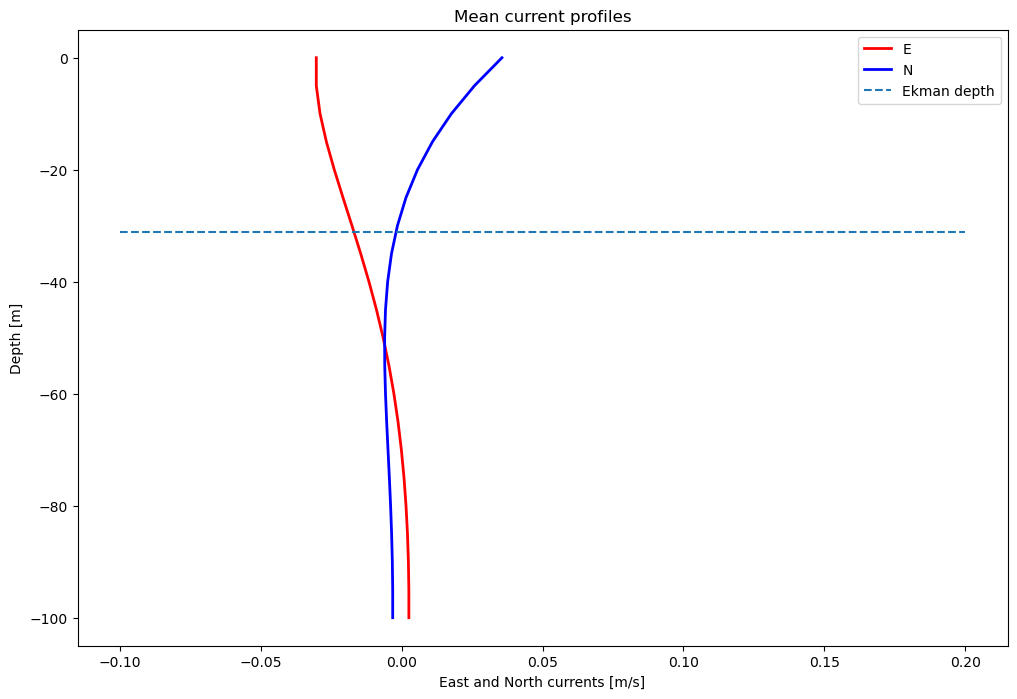

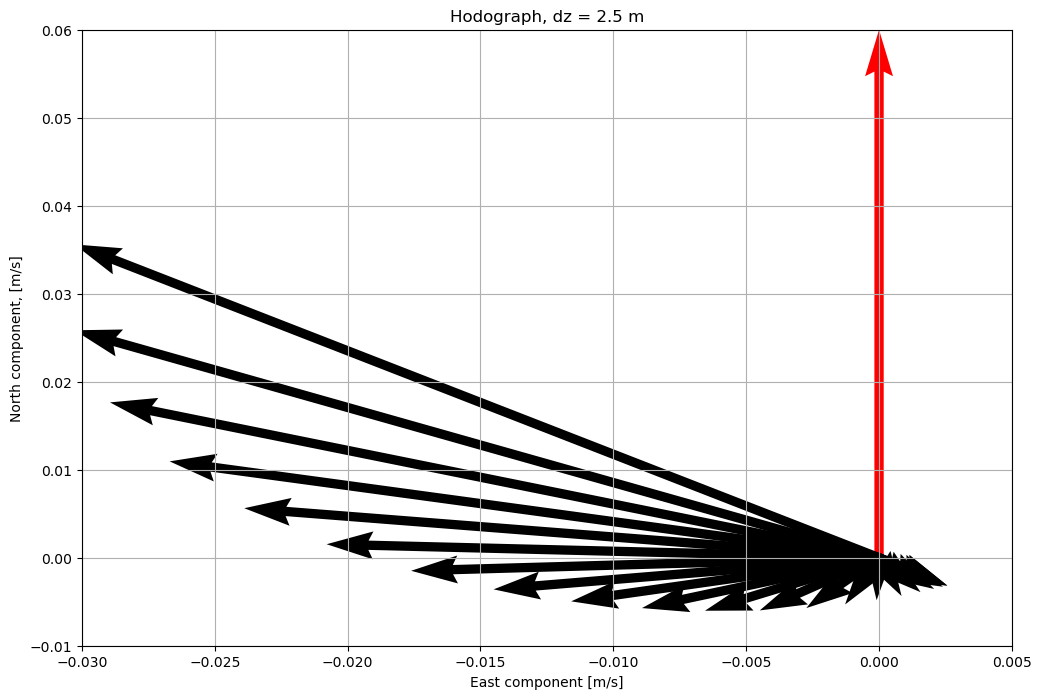

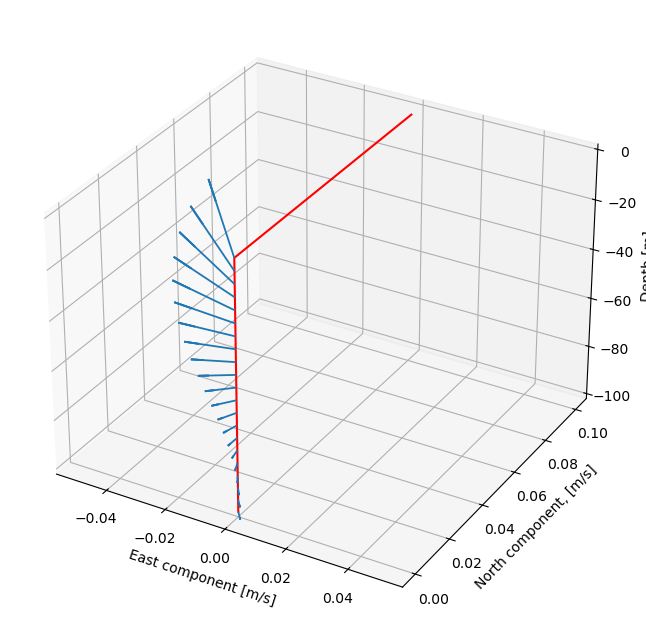

In [114]:
# Variables and Initial conditions
u = np.zeros(z.shape)         #  the dependent variable, velocity
v = np.zeros(z.shape) 
uavg = np.zeros(z.shape) 
vavg = np.zeros(z.shape) 
navg = 0

#initialise 
delsqu = np.zeros(z.shape)
delsqv = np.zeros(z.shape)

usurf = np.zeros((nstep, 1))
vsurf = np.zeros((nstep, 1))
umid = np.zeros((nstep, 1))
vmid = np.zeros((nstep, 1))
udeep = np.zeros((nstep, 1))
vdeep = np.zeros((nstep, 1))

transu = np.zeros((nstep, 1))
transv = np.zeros((nstep, 1))

# set figure attributes
f1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))


ax1.set_ylabel('depth [m]')
ax1.set_xlabel('Zonal current [m/s]')
ax1.set_title(r'Upper ocean Ekman layer, $\tau_y = 0.1 N m^{-2}$')
    

ax2.set_ylabel('depth [m]')
ax2.set_xlabel('Meridional current, [m/s]')


#  begin time-stepping
ht = [] # handle for the time string in the figure
for n in range(nstep):
    
    # advance time
    time[n] = (n-1)*dt


    # evaluate the diffusion term
    delsqu = np.concatenate(([0], u[:-2] - 2*u[1:-1] + u[2:], [0]))
    delsqv = np.concatenate(([0], v[:-2] - 2*v[1:-1] + v[2:], [0]))
    
    # Euler forward solution with Coriolis
    u = u + w*delsqu + dt*f*v
    v = v + w*delsqv - dt*f*u
    

    # Apply the surface boundary condition
    u[0] = u[1] + dz * (Tauwx / (rho0 * A))
    v[0] = v[1] + dz * (Tauwy / (rho0 * A))

    # Apply the bottom boundary condition (Neumann, free-slip)
    u[-1] = u[-2]
    v[-1] = v[-2]
    
    # Diagnostics
    
    #  1) time-average (after the first day)
    if time[n]/SECPERDAY >= 1:
        uavg = uavg + u
        vavg = vavg + v
        navg = navg + 1
    
    
    # 2) time series of surface current
    usurf[n] = u[0]
    vsurf[n] = v[0]
    mid = int(np.round(2*nz/3) -2)
    umid[n] = u[mid]
    vmid[n] = v[mid]
    udeep[n] = u[nz-4]
    vdeep[n] = v[nz-4]

    # 3) time series of transport
    transu[n] = (sum(u) - u[0])*dz
    transv[n] = (sum(v) - v[0])*dz

    # plot profile every nplot time steps
    if (n % nplot) == nplot - 1:
        #figure(f1)
        ax1.plot(u, z)
        ax2.plot(v, z)
        #if ht == []:
        #    del ht
        #ht=plt.text(-0.03,-90,['time=',num2str(time(n)/SECPERDAY,3)])
        

# compute mean profile
#uavg = uavg/navg
#vavg = vavg/navg

print("navg", navg)
if navg > 0:
    uavg /= navg
    vavg /= navg

#  plot diagnostics
# Theoretical Ekman transport and Ekman depth
Ektrans = np.sqrt(Tauwx**2+Tauwy**2)/rho0/f
Ekdepth = np.sqrt(2*A/abs(f))

# time series at different depths
dtime=time/SECPERDAY
f1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(dtime, usurf, label = "Surface")
ax1.plot(dtime, umid, label="Midwater")
ax1.plot(dtime, udeep, label="Deepwater")
ax1.set_ylabel('East [m/s]')
ax1.grid(True)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_title('East and North currents')


ax2.plot(dtime, vsurf, label='Surface')
ax2.plot(dtime, vmid, label='Midwater')
ax2.plot(dtime, vdeep, label='Deepwater')
ax2.set_ylabel('North [m/s]')
ax2.set_xlabel('time [day]')
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.grid(True)

# transport
f1, ax = plt.subplots(figsize=(12, 8))
ax.plot(transu, transv, linestyle='dotted', label='instantaneous')

Tx = np.mean(transu)
Ty = np.mean(transv)
ax.plot([0,Tx], [0, Ty], 'g-o', label='average')
ax.plot([0,Ektrans], [0,0],'r-+', label='theoretical')
ax.set_xlabel('U transport [m2/s]')
ax.set_ylabel('V transport [m2/s]')
# axis([-0.1 0.15 -0.25 0.])
ax.axis('equal')
ax.set_title('Transport with time, average and theoretical value')
ax.grid(True)
ax.legend()

# mean velocity profiles
f1, ax = plt.subplots(figsize=(12, 8))
ax.plot(uavg, z,'r',linewidth=2, label='E')
ax.plot(vavg, z,'b',linewidth=2, label='N')
ax.set_xlabel('East and North currents [m/s]')
ax.set_ylabel('Depth [m]')
ax.set_title('Mean current profiles')

h, = ax.plot([-0.1, 0.2], [-Ekdepth, -Ekdepth], linestyle='--', label='Ekman depth')
ax.legend()

#hodograph
f1, ax = plt.subplots(figsize=(12, 8))
ax.quiver(0, 0, 0, 0.06, color='r', angles='xy', scale_units='xy', scale=1, width=0.01)
print(uavg)
print(vavg)
ax.quiver(np.zeros(uavg.shape),np.zeros(uavg.shape),uavg,vavg,angles='xy', scale_units='xy', scale=1, width=0.01)
ax.set_xlabel('East component [m/s]')
ax.set_ylabel('North component, [m/s]')
ax.set_title('Hodograph, dz = 2.5 m')
ax.set_xlim(-0.03, 0.005)
ax.set_ylim(-0.01, 0.06)
ax.grid(True)


# spiral in 3D
f1, ax = plt.subplots(subplot_kw={'projection':'3d'}, figsize=(12, 8))
h1 = ax.quiver(np.zeros(uavg.shape), np.zeros(uavg.shape), z, uavg, vavg, np.zeros(uavg.shape), linewidth=1.3)
x3 = [0, 0, 0]
y3 = [0, 0, 0.1]
z3 = [-L, 0, 0]

h2, = ax.plot(x3, y3, z3, 'r-', linewidth=1.5)
ax.set_xlabel('East component [m/s]')
ax.set_ylabel('North component, [m/s]')
ax.set_zlabel('Depth [m]')
ax.grid(True)
